# Generative Adversial Neural Networks

Generative adversarial networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. They were introduced by Ian Goodfellow et al. in 2014. This technique can generate photographs that look at least superficially authentic to human observers, having many realistic characteristics (though in tests people can tell real from generated in many cases)

https://en.wikipedia.org/wiki/Generative_adversarial_network

https://github.com/kroosen/GAN-in-keras-on-mnist/blob/master/GAN-keras-mnist-MLP.ipynb

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train[60:]
Y_train = Y_train[10:]

z_dim = 50

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [2]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(32, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(64, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(128, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(128, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(64, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(32, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in range(1, epochs+1):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()

In [0]:
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Epochs: 200
Batch size: 32
Batches per epoch: 1873
--------------- Epoch 1 ---------------


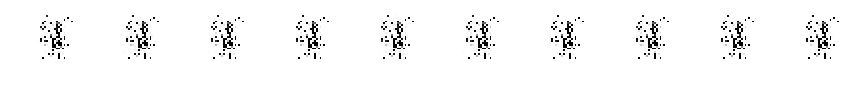

--------------- Epoch 2 ---------------


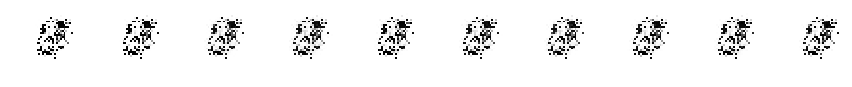

--------------- Epoch 3 ---------------


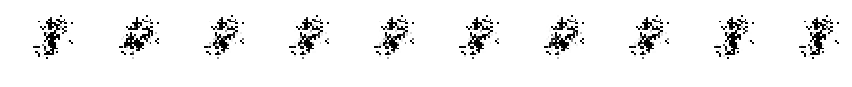

--------------- Epoch 4 ---------------


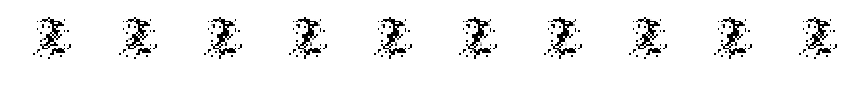

--------------- Epoch 5 ---------------


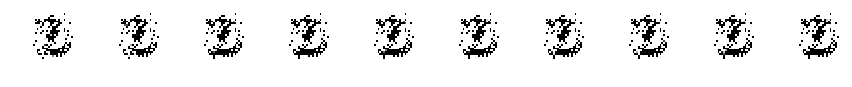

--------------- Epoch 6 ---------------


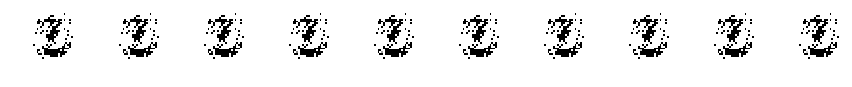

--------------- Epoch 7 ---------------


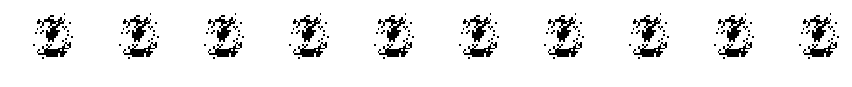

--------------- Epoch 8 ---------------


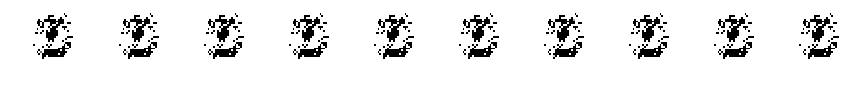

--------------- Epoch 9 ---------------


In [0]:
train(epochs=200, plt_frq=1, BATCH_SIZE=32)